In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
#from kneed import KneeLocator
#from sklearn.datasets import make_classification
#from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from sklearn.datasets import make_blobs
from os import listdir
from os.path import isfile, join
import os
import datetime as dt
import scipy.io
import glob
import pyresample
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import netCDF4
import datetime as dt
from netCDF4 import date2num,num2date
import matplotlib.colors as colors
import matplotlib as mpl
from netCDF4 import Dataset
import IPython.display
import cmocean
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
#import cosima_cookbook as cc
#from mpl_toolkits.basemap import Basemap
import math
import time
import sys

# Plotting
from scipy.stats import gaussian_kde
import seaborn as sns
from sklearn import linear_model


# Parallel computing
%matplotlib inline
from dask.distributed import Client


def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()
    
    
import mpl_scatter_density # adds projection='scatter_density'
#from matplotlib.colors import LinearSegmentedColorma

# "Viridis-like" colormap with white background
# white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
#     (0, '#ffffff'),
#     (1e-20, '#440053'),
#     (0.2, '#404388'),
#     (0.4, '#2a788e'),
#     (0.6, '#21a784'),
#     (0.8, '#78d151'),
#     (1, '#fde624'),
# ], N=256)
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y)#, cmap = cmo.deep)
    fig.colorbar(density, label='Number of points per pixel')


In [4]:
# Save SWH and aice over time into a new netcdf
savepath_nc = '/g/data/ia40/sea-ice-classification/'
savefilename = savepath_nc + 'waves-sep-2019.nc'
# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-025-2019/history/'
year = 2019

# Start
os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh_01h.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lon,n_lat = LN.shape
n_days = len(onlyfiles)
print(n_days)
n_days = 48
aice_array =  np.empty((n_days,n_lon,n_lat))
swh_array =  np.empty((n_days,n_lon,n_lat))
ppd_array =  np.empty((n_days,n_lon,n_lat))
# Loop over every file
day_vec = range(0,n_days,1)
file_dates = []

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    file_dates.append(np.datetime64(filename[-19:-9]))
    ds = xr.open_dataset(filename)
    aice_array[day_idx,:,:] = ds.aice.values
    swh_array[day_idx,:,:] = ds.wave_sig_ht.values
    ppd_array[day_idx,:,:] = ds.peak_period.values
            
print('Done!') 

# Save to netCDF
ds = xr.open_dataset(filename)
HTE = ds.HTE.values
HTN = ds.HTN.values
tarea = ds.tarea.values
tmask = ds.tmask.values

d_vars = {"aice" : (['time','nj','ni'],aice_array,
                              {'long_name' :"Areal sea ice area proportion of cell",
                               'units'     :"-",
                               '_FillValue':-2e8}),
          "wave_sig_ht" : (['time','nj','ni'],swh_array,
                              {'long_name' :"Signficant wave height",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "peak_period" : (['time','nj','ni'],ppd_array,
                              {'long_name' :"Peak period",
                               'units'     :"s",
                               '_FillValue':-2e8}),
          "HTE" : (['nj','ni'],HTE,
                          {'long_name':"T cell width on East side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "HTN" : (['nj','ni'],HTN,
                          {'long_name':"T cell width on North side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "tarea" : (['nj','ni'],tarea,
                          {'long_name':"area of T grid cells",
                           'units'    :"m^2",
                           '_FillValue':-2e8}),
          "tmask" : (['nj','ni'],tmask,
                          {'long_name':"ocean grid mask",
                           'units'    :"Boolean",
                           '_FillValue':-2e8})}

coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
          "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
          "time" : (["time"],file_dates)}
attrs = {'creation_date': "2023-05-14",#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "Hourly waves from CICE-WIM standalone 1/4-degree data",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(savefilename,unlimited_dims=['time'],compute=False)

2019
720
Progress: [####################] 100% 
Progress: [####################] 100% 
Done!


In [57]:
## Read in sig. wave height and calculate the penetrative distance

# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-025-2019/history/'
year = 2019

# Start
os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh_01h.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()

# xr.open_mfdataset('my/files/*.nc', parallel=True)

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lon,n_lat = LN.shape
n_days = len(onlyfiles)
print(n_days)
wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))

std_swh = 0.1 # np.nanstd(wave_sig_ht)
# Loop over every file
day_vec = range(0,24*5,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.01)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        if swh_idx.any():
#            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()
            
            # (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            wave_penetration_array[day_idx,lon_idx] =  np.nan
            
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = np.nan
            
print('Done!')        

2019
720
Progress: [####################] 100% 
Progress: [####################] 100% 
Done!


In [ ]:
# Improving efficiency

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lon,n_lat = LN.shape
n_days = len(onlyfiles)
print(n_days)
wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))
std_swh = np.nanstd(wave_sig_ht)

# Loop over every file
day_vec = range(244-1,244+29,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.15)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > 0.3# std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        if swh_idx.any():
            wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()
            
#            (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            wave_penetration_array[day_idx,lon_idx] =  np.nan
            
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = wave_sig_ht[0,temp_locs[-1],lon_idx]
            #np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = np.nan
            
print('Done!')

In [3]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 2
Total threads: 4,Total memory: 1.86 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42279,Workers: 2
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 1.86 GiB
Comm: tcp://127.0.0.1:44057,Total threads: 2
Dashboard: /proxy/45545/status,Memory: 0.93 GiB
Nanny: tcp://127.0.0.1:36269,


In [25]:
ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [26]:
da = ds['air']
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-4b34f6caf6d23c36deacd8ce94608c01air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [27]:
da2 = da.groupby('time.month').mean('time')
da3 = da - da2
da3

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)>
dask.array<sub, shape=(2920, 25, 53, 12), dtype=float32, chunksize=(2920, 25, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [2]:
import numpy as np
import xarray as xr
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])



In [ ]:
da_smooth = daice.rolling(time=30).mean().persist()
da_smooth
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr
corr.plot(figsize=(12, 8))

In [39]:
ds = xr.open_dataset('/g/data/ia40/cice-dirs/runs/waves-025-2019/history/iceh_01h.2019-09-01-03600.nc',
                              chunks={'nj': 1080, 'ni': 1440, 'time': -1})
#('/g/data/ia40/sea-ice-classification/waves-sep-2019.nc')
ds

<xarray.Dataset>
Dimensions:        (time: 1, d2: 2, nj: 1080, ni: 1440, nc: 5, nkaer: 5, nf: 12)
Coordinates:
  * time           (time) datetime64[ns] 2019-09-01T01:00:00
    TLON           (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT           (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON           (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT           (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    NCAT           (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    NFSD           (nf) float32 dask.array<chunksize=(12,), meta=np.ndarray>
Dimensions without coordinates: d2, nj, ni, nc, nkaer, nf
Data variables: (12/24)
    time_bounds    (time, d2) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDa          (nkaer) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    tmask          (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    blkmask        (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    tarea          (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    uarea          (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ...             ...
    dafsd_newi     (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_latg     (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_latm     (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_wave     (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    dafsd_weld     (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 1080, 1440), meta=np.ndarray>
    afsdn          (nc, nf, nj, ni) float32 dask.array<chunksize=(5, 12, 1080, 1440), meta=np.ndarray>
Attributes:
    title:        sea ice model output for CICE
    contents:     Diagnostic and Prognostic Variables
    source:       Los Alamos Sea Ice Model, CICE_6.2.0
    comment:      This year has 365 days
    comment2:     File written on model date 20190901
    comment3:     seconds elapsed into model date:   3600
    conventions:  CF-1.0
    history:      This dataset was created on 2023-05-14 at 17:38:13.4
    io_flavor:    io_netcdf

In [40]:
dswh = ds['wave_sig_ht']
dswh

<xarray.DataArray 'wave_sig_ht' (time: 1, nj: 1080, ni: 1440)>
dask.array<open_dataset-07a74378716baa2eaaa5e7a181f4d3fawave_sig_ht, shape=(1, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-09-01T01:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          m
    long_name:      significant height of wind and swell waves
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [41]:
daice = ds['aice']
daice

<xarray.DataArray 'aice' (time: 1, nj: 1080, ni: 1440)>
dask.array<open_dataset-07a74378716baa2eaaa5e7a181f4d3faaice, shape=(1, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-09-01T01:00:00
    TLON     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    TLAT     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULON     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    ULAT     (nj, ni) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

In [ ]:
# Wave penetration
def wave_calculation_gufunc(swh, aice):
    return aice

def wave_penetration_gufunc(swh, aice):
    swh_ranks = bottleneck.rankdata(swh, axis=-1)
    aice_ranks = bottleneck.rankdata(aice, axis=-1)
    return wave_calculation_gufunc(swh_ranks, aice)

def wave_penetration(swh, aice, dim):
    return xr.apply_ufunc(
        wave_penetration_gufunc, swh, aice,
#        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])




# test = wave_penetration(dswh.chunk({'time': -1}),
#                             daice.chunk({'time': -1}),
#                             'time')

# #test.plot(figsize=(12, 8))
# test[1,1]

da_smooth = dswh.rolling(time=30).mean().persist()
da_smooth
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr
corr.plot(figsize=(12, 8))

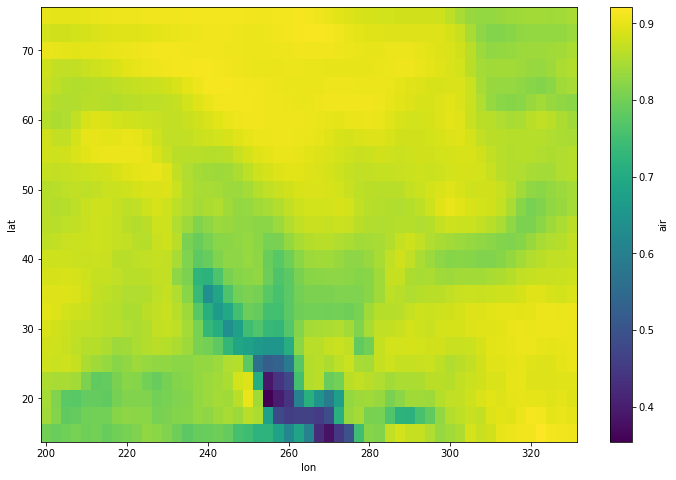

In [7]:
da_smooth = da.rolling(time=30).mean().persist()
da_smooth
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr
corr.plot(figsize=(12, 8))

In [33]:
ds['wave_sig_ht'][0,:,lon_idx].shape

#locs = np.asarray(ice_idx==True).nonzero()
#locs[1]

#tmp_wave_sig_ht = wave_sig_ht.copy
#tmp_wave_sig_ht[tmp_wave_sig_ht < 0.01] = np.nan
#np.nanstd(tmp_wave_sig_ht)

# (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()


# print(wave_sig_ht[0,lon_idx,temp_locs[-1]])

# wave_sig_ht = ds.wave_sig_ht.values
# wave_sig_ht.max
# wave_sig_ht

# swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > 0.38
# swh_idx_tmp

# np.nanmax(wave_sig_ht[0,:,lon_idx])

np.nanstd(wave_sig_ht)
savepath

'/home/566/nd0349/notebooks/'

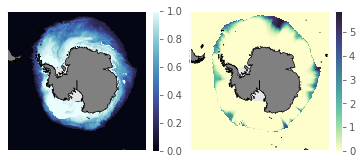

In [48]:
fontprops = fm.FontProperties(size=18)
plt.figure()
cmap = cmo.deep
coord_lims = [-180, 180, -50, -90]

ax = plt.subplot(1, 2, 0+1, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, ds['aice'][0,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmo.ice,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)  

ax = plt.subplot(1, 2, 0+2, projection=ccrs.SouthPolarStereo())
ax.set_extent(coord_lims, ccrs.PlateCarree())
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                            edgecolor='black', facecolor='gray', linewidth=0.5)
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
p = ax.pcolormesh(LN, LT, ds['wave_sig_ht'][0,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmap,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')
cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)

plt.savefig(savepath+'aice_fsdrad_hour.png', dpi = 300)  

/jobfs/84160694.gadi-pbs/ipykernel_1332118/1020072649.py:4: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  fig.colorbar(density, label='Point density')


1.8143864870071411

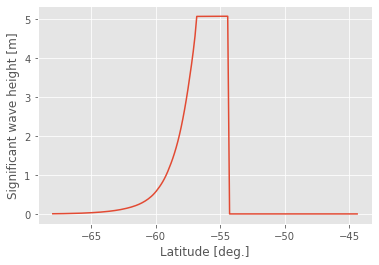

In [49]:
plt.style.use("ggplot")
ax = plt.subplot()
ax.plot(LT[0:300,0],ds['wave_sig_ht'][0,0:300,0])
fig.colorbar(density, label='Point density')
plt.ylabel("Significant wave height [m]")
plt.xlabel("Latitude [deg.]")

incident_swh_array[0,0]

(83251,)

(6348,)


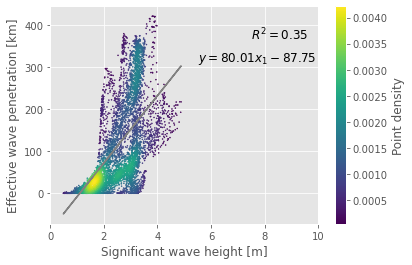

In [56]:
# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = wave_penetration_array[0:10,:]
temp_swh = incident_swh_array[0:10,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)
# Generate fake data
x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Point density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Effective wave penetration [km]")
plt.xlim([0, 10])
ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
ax.text(0.55, 0.75, '$y = %.2f x_1 - %.2f $' % (model.coef_[0], abs(model.intercept_)), fontsize=12, transform=ax.transAxes)
#plt.ylim([0, 1000])
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh.png', dpi = 300)  
plt.show()

142.84389286478427
105.1418376022407


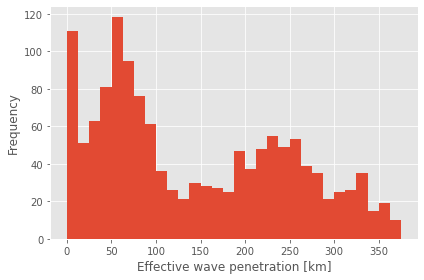

In [52]:
#plot_swh
eps = 0.2
idx = np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)
plot_swh[idx]

n_bins = 30
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs.hist(plot_wave_pen[idx]/1000,  bins=n_bins)
plt.xlabel("Effective wave penetration [km]")
plt.ylabel("Frequency")

print(np.mean(plot_wave_pen[idx]/1000))
print(np.std(plot_wave_pen[idx]/1000))

In [14]:
#idx.shape
#x
#y
temp_pen
#wave_penetration_array[0,:].shape
plot_swh

array([], dtype=float64)

In [ ]:

wave_penetration_array.shape
onlyfiles[1]
day_vec
LN.shape
LN[1,1:20]
swh_idx

wave_penetration_array
sum(swh_idx)
wave_penetration_array
swh_idx.any()

(ds['aice'][0:100,lon_idx].values > 0.1).all()
#ds['wave_sig_ht'][0:100,lon_idx].values > 0.3

swh_idx.any()
swh_idx[0,200:600]
swh_idx.shape
ds['HTE'].shape
print(lon_idx)


temp = ds['HTE'].values
print(temp.shape)
print(swh_idx.shape)
temp[lon_idx,swh_idx[0,:]]

 
wave_penetration_array

# Daily CICE data

In [24]:
# Daily output
## Read in sig. wave height and calculate the penetrative distance

# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-025/history/'
year = 2018

# Start
os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh.*{year}*-09-*".format(path=mypath, year=year))
onlyfiles.sort()

# xr.open_mfdataset('my/files/*.nc', parallel=True)

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lon,n_lat = LN.shape
n_days = len(onlyfiles)
print(n_days)
wave_penetration_array = np.empty((n_days,n_lon))
effective_wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))

std_swh = 0.1 # np.nanstd(wave_sig_ht)
# Loop over every file
day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.01)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        if swh_idx.any():
#            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            effective_wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()

            # (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            wave_penetration_array[day_idx,lon_idx] =  np.nan
            effective_wave_penetration_array[day_idx,lon_idx] =  np.nan
            
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = np.nan
            
print('Done!')    

2018
30
Progress: [####################] 100% 
Progress: [####################] 100% 
Done!


In [5]:
np.nanstd(wave_sig_ht)

0.49133638

(32398,)


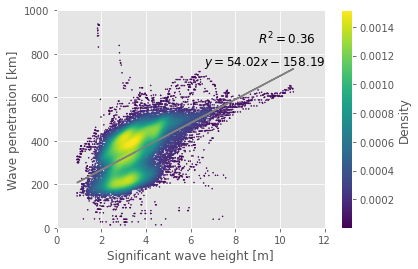

In [32]:
# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = wave_penetration_array[:,:]
temp_swh = incident_swh_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)
# Generate fake data
x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Wave penetration [km]")
plt.xlim([0, 12])
plt.ylim([0, 1000])


# now plot both limits against eachother
#ax.plot([0,8], [0,800], 'k-', alpha=0.75, zorder=0)


ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh_daily_2018-linear.png', dpi = 1000)  
plt.show()

<Figure size 432x288 with 0 Axes>

In [13]:
# Plot the spread of the effective penetration distance given a SWH interval
eps = 0.2
idx = np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)
d = {'swh':plot_swh[idx], 'wave_pen': plot_wave_pen[idx]}
df_wave_pen = pd.DataFrame(data=d)

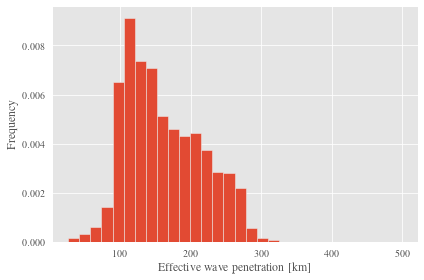

161.77144622572038
55.172801614867055


In [141]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 30
fig, axs = plt.subplots(sharey=True, tight_layout=True)
# # We can set the number of bins with the *bins* keyword argument.
eps = 0.5
idx = np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)
axs.hist(plot_wave_pen[idx]/1000,  bins=n_bins, density = True)
plt.xlabel("Effective wave penetration [km]")
plt.ylabel("Frequency")

#fig, ax = plt.subplots()

# Density Plot and Histogram of wave penetration distances given SWH around 3m
#sns.histplot(data=df_wave_pen, x="wave_pen", kde=True, binwidth=0.1)
#plt.xlim([0, 10])

#ax.set_xlabel('"Effective wave penetration [km]"')
#ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
plt.show()

print(np.mean(plot_wave_pen[idx]/1000))
print(np.std(plot_wave_pen[idx]/1000))

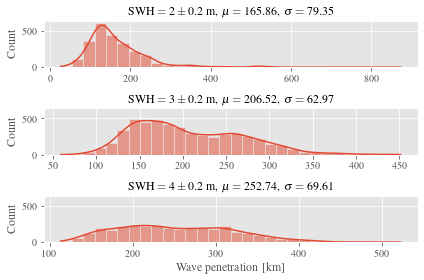

227.96196706211418
82.31822028535687


In [5]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 30


eps = 0.2
data = {
    '1' : plot_wave_pen[np.logical_and(plot_swh>1.0-eps, plot_swh<1.0+eps)],
    '2' : plot_wave_pen[np.logical_and(plot_swh>2.0-eps, plot_swh<2.0+eps)],
    '3' : plot_wave_pen[np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)],
    '4' : plot_wave_pen[np.logical_and(plot_swh>4.0-eps, plot_swh<4.0+eps)],
    '5' : plot_wave_pen[np.logical_and(plot_swh>5.0-eps, plot_swh<5.0+eps)],
    '6' : plot_wave_pen[np.logical_and(plot_swh>6.0-eps, plot_swh<6.0+eps)],
    '7' : plot_wave_pen[np.logical_and(plot_swh>7.0-eps, plot_swh<7.0+eps)],
    '8' : plot_wave_pen[np.logical_and(plot_swh>8.0-eps, plot_swh<8.0+eps)],
}


#sns.histplot(data=plot_wave_pen[idx]/1000, kde=True, bins=n_bins)
fig, axs = plt.subplots(3,1,sharey=True, tight_layout=True)
sns.histplot(data=data['2']/1000, kde=True, bins=n_bins, ax=axs[0])
axs[0].set_title('SWH $= 2\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['2']/1000), np.std(data['2']/1000)), fontsize=12)
sns.histplot(data=data['3']/1000, kde=True, bins=n_bins, ax=axs[1])
axs[1].set_title('SWH $= 3\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['3']/1000), np.std(data['3']/1000)), fontsize=12)
sns.histplot(data=data['4']/1000, kde=True, bins=n_bins, ax=axs[2])
axs[2].set_title('SWH $= 4\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['4']/1000),np.std(data['4']/1000)), fontsize=12)
plt.xlabel("Wave penetration [km]")
plt.ylabel("Count")
# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'histogram.png', dpi = 300)  
plt.show()

print(np.mean(plot_wave_pen[idx]/1000))
print(np.std(plot_wave_pen[idx]/1000))



5224

In [ ]:
fig, axs = plt.subplot_mosaic([['a)','b)', 'c)']],
                              nrows=3,ncols=1,
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(12,4.5))
plt.rcParams["font.family"] = "serif"
n_clusters = 2
for label, ax in axs.items():
    readfilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
    ds = xr.open_dataset(readfilename)
    plot_data = ds['k'][243,:,:]
    cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:], plot_data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                shading='auto')

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
    ax.set_extent(coord_lims, ccrs.PlateCarree())
    
    # Add coastlines
    ax.add_feature(land_50m)
    ax.coastlines()
    n_clusters = n_clusters + 1

<AxesSubplot:ylabel='Count'>

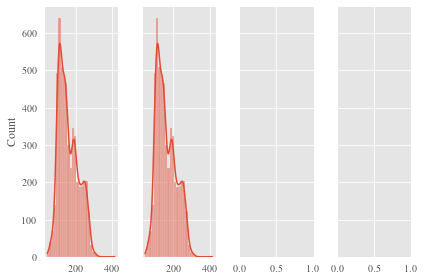

(32400,)

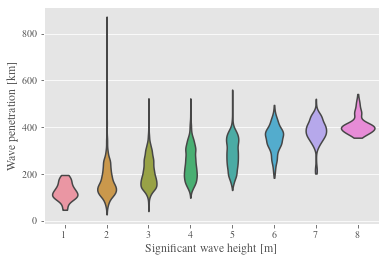

In [6]:
# Violin plot
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")

eps = 0.5
data = {
    '1' : plot_wave_pen[np.logical_and(plot_swh>1.0-eps, plot_swh<1.0+eps)],
    '2' : plot_wave_pen[np.logical_and(plot_swh>2.0-eps, plot_swh<2.0+eps)],
    '3' : plot_wave_pen[np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)],
    '4' : plot_wave_pen[np.logical_and(plot_swh>4.0-eps, plot_swh<4.0+eps)],
    '5' : plot_wave_pen[np.logical_and(plot_swh>5.0-eps, plot_swh<5.0+eps)],
    '6' : plot_wave_pen[np.logical_and(plot_swh>6.0-eps, plot_swh<6.0+eps)],
    '7' : plot_wave_pen[np.logical_and(plot_swh>7.0-eps, plot_swh<7.0+eps)],
    '8' : plot_wave_pen[np.logical_and(plot_swh>8.0-eps, plot_swh<8.0+eps)],
}
maxsize = max([a.size for a in data.values()])
data_pad = {k:np.pad(v, pad_width=(0,maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in data.items()}
df = pd.DataFrame(data_pad)

plt.style.use("ggplot")
fig, ax = plt.subplots()
sns.violinplot(data=df/1000, cut=0,inner=None,scale="area")
ax.set_xlabel('Significant wave height [m]')
ax.set_ylabel('Wave penetration [km]')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'violin_plot.png', dpi = 300)  
plt.show()

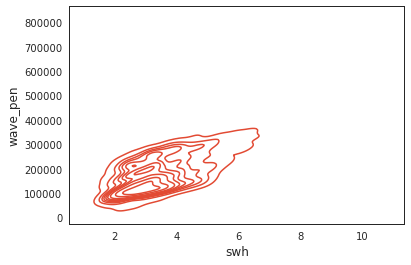

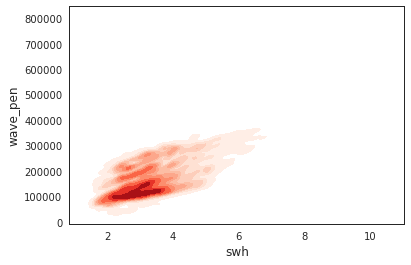

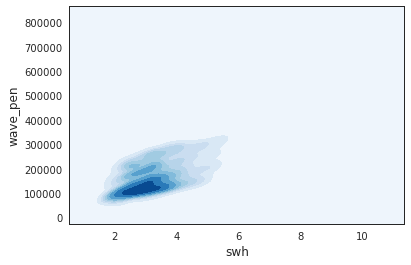

In [ ]:

# set seaborn style
#sns.set_style("white")

plt.style.use("ggplot")
fig, ax = plt.subplots()

# # Basic 2D density plot
# sns.kdeplot(x=df.swh, y=df.wave_pen)
# plt.show()
 
# Custom the color, add shade and bandwidth
sns.kdeplot(x=df.swh, y=df.wave_pen, cmap="Reds", fill=True, bw_adjust=.5)
ax.set_xlabel('Significant wave height [m]')
ax.set_ylabel('Wave penetration distance [km]')
plt.show()


# # Add thresh parameter
# sns.kdeplot(x=df.swh, y=df.wave_pen, cmap="Blues", fill=True, thresh=0)
plt.show()

In [20]:
d = {'swh':plot_swh, 'wave_pen': plot_wave_pen/1000}
df = pd.DataFrame(data=d)

In [ ]:

from scipy.stats import kde

#xi, yi, zi, = x_kde, y_kde, z_kde

x=df.swh
y=df.wave_pen

nbins = 500

k = gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


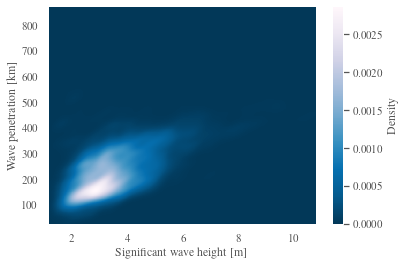

In [28]:
# Make the 2D density plot
# https://www.python-graph-gallery.com/85-density-plot-with-matplotlib
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
fig, ax = plt.subplots()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = plt.cm.PuBu_r)#,#cmap=cmo.dense)#,
#               norm=colors.LogNorm(vmin=0.00000001, vmax=0.0001))
plt.colorbar(extend=None, label='Density')
ax.set_xlabel('Significant wave height [m]')
ax.set_ylabel('Wave penetration [km]')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'2d_density.png', dpi = 300)  
plt.show()

<AxesSubplot:xlabel='swh', ylabel='wave_pen'>

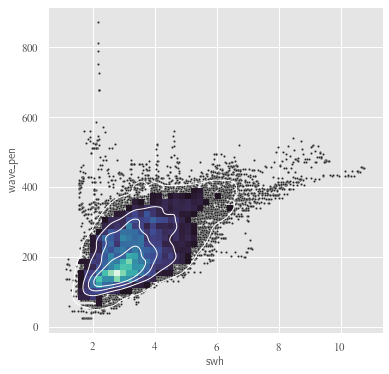

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

d = {'swh':plot_swh, 'wave_pen': plot_wave_pen/1000}
df = pd.DataFrame(data=d)
# set seaborn style
#sns.set_style("white")

plt.style.use("ggplot")

# # Basic 2D density plot
# sns.kdeplot(x=df.swh, y=df.wave_pen)

# Simulate data from a bivariate Gaussian
#n = 10000
#mean = [0, 0]
#cov = [(2, .4), (.4, .2)]
#rng = np.random.RandomState(0)
#x, y = rng.multivariate_normal(mean, cov, n).T
x=df.swh
y=df.wave_pen
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)


KeyboardInterrupt



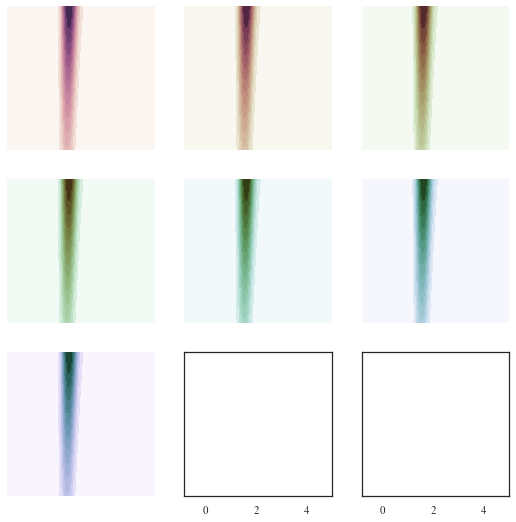

In [19]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
#    x, y = rs.normal(size=(2, 50))
    sns.kdeplot(
        x=x, y=y,
        cmap=cmap, fill=True,
        clip=(-5, 5), cut=10,
        thresh=0, levels=15,
        ax=ax,
    )
    ax.set_axis_off()

ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
f.subplots_adjust(0, 0, 1, 1, .08, .08)

In [13]:
np.asarray(zi).shape

(32400,)

In [9]:
df_wave_pen["wave_pen"].shape
#wave_penetration_array.shape

(263,)

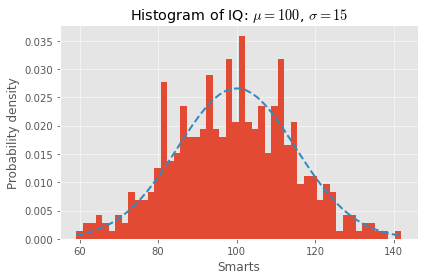

In [20]:
# example data
plt.style.use("ggplot")
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = mu + sigma * np.random.randn(437)

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=True)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()


## k-means vs wave penetration

## k-means vs wave penetration

In [117]:
# Daily output
## Read in sig. wave height and calculate the penetrative distance

# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2015

# Start
os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh.*{year}*-09-*".format(path=mypath, year=year))
onlyfiles.sort()

# xr.open_mfdataset('my/files/*.nc', parallel=True)

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

ds_tmp = xr.open_dataset('/g/data/ia40/sea-ice-classification/kmean_' + str(year) + '.nc')
k_array = ds_tmp['k'][243:(243+30),:,:]

# Initialise arrays
n_lat,n_lon = LN.shape
n_days = len(onlyfiles)
print(n_days)
wave_penetration_array = np.empty((n_days,n_lon))
effective_wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))
miz_width_array = np.empty((n_days,n_lon))

std_swh = 0.1 # np.nanstd(wave_sig_ht)
# Loop over every file
day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.01)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        
        miz_idx = (k_array[day_idx,:,lon_idx].values == 0)*ice_idx
        if swh_idx.any():
#            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            effective_wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()
            # (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            wave_penetration_array[day_idx,lon_idx] =  np.nan
            effective_wave_penetration_array[day_idx,lon_idx] =  np.nan
            
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = np.nan
            
            
        if miz_idx.any():
            miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][0,miz_idx,lon_idx].data).sum()
            #ds['HTE'][miz_idx,lon_idx].data.sum ()
            #np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][0,miz_idx,lon_idx].data).sum()
        else:
            miz_width_array[day_idx,lon_idx] = np.nan
            
print('Done!')    

2015
30
Progress: [####################] 100% 
Progress: [####################] 100% 
Done!


In [ ]:
print(miz_idx.shape)
#print(sic_idx.shape)
(k_array[day_idx,:,lon_idx].values == 0).shape

#ds['HTE'][miz_idx,lon_idx]
ds['HTE'].shape
lon_idx
miz_idx

(9307,)


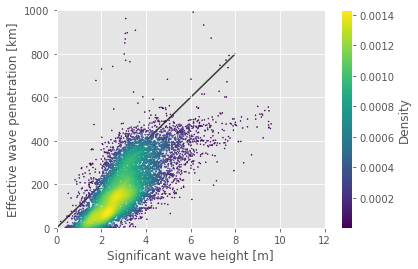

In [119]:
# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = effective_wave_penetration_array[:,:]
#wave_penetration_array[:,:]
temp_swh = incident_swh_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)
# Generate fake data
x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
#ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Effective wave penetration [km]")
plt.xlim([0, 12])
plt.ylim([0, 1000])


# now plot both limits against eachother
ax.plot([0,8], [0,800], 'k-', alpha=0.75, zorder=0)


#ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
#ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh_daily_1deg_'+str(year)+'.png', dpi = 1000)  
plt.show()

(10509,)


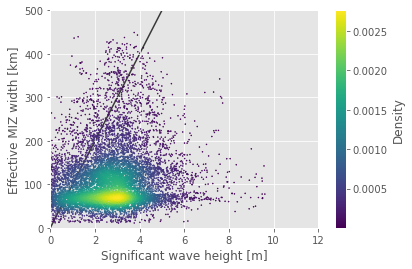

In [125]:
# Read in MIZ width
filename = '/g/data/ia40/sea-ice-classification/mizWidth_2018.nc'
ds = xr.open_dataset(filename)

range(243,243+30)

# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = miz_width_array[:,:]
temp_swh = incident_swh_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
idx = np.logical_or(idx, (np.abs(temp_pen)<100)) 
# #idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
# idx = temp_swh > 1.0
# #plot_swh = incident_swh_array.reshape(-1)[idx]
# #temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)

#plot_swh = temp_swh.reshape(-1)
#plot_wave_pen = temp_pen.values.reshape(-1)



x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x,y,z#x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
#ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Effective MIZ width [km]")
plt.xlim([0, 12])
plt.ylim([0, 500])


# now plot both limits against eachother
ax.plot([0,8], [0,800], 'k-', alpha=0.75, zorder=0)


#ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
#ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'miz_width_vs_swh_daily_1deg_'+str(year)+'.png', dpi = 1000)  
plt.show()

(9070,)


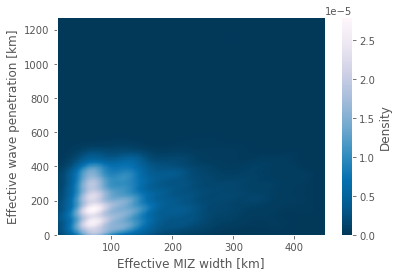

In [139]:
# Read in MIZ width
filename = '/g/data/ia40/sea-ice-classification/mizWidth_2018.nc'
ds = xr.open_dataset(filename)

range(243,243+30)

# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = effective_wave_penetration_array[:,:]
temp_swh = miz_width_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
idx = np.logical_or(idx, (np.abs(temp_swh)<100)) 
# #idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
# idx = temp_swh > 1.0
# #plot_swh = incident_swh_array.reshape(-1)[idx]
# #temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)

#plot_swh = temp_swh.reshape(-1)
#plot_wave_pen = temp_pen.values.reshape(-1)

x = plot_swh/1000
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x,y,z#x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")


nbins = 500

k = gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


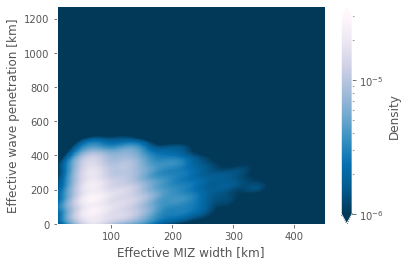

In [156]:

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
#density = ax.scatter(x_kde, y_kde, c=z_kde, s=20)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = plt.cm.PuBu_r,#cmap=cmo.dense)#,
               norm=colors.LogNorm(vmin=0.000001, vmax=0.00003))
plt.colorbar(extend='both', label='Density')
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
#ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
#fig.colorbar(density, label='Density')
plt.xlabel("Effective MIZ width [km]")
plt.ylabel("Effective wave penetration [km]")

#plt.xlim([0, 500])
#plt.ylim([0, 500])

# now plot both limits against eachother
#ax.plot([0,800], [0,800], 'k-', alpha=0.75, zorder=0)


#ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
#ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave_pen_vs_miz_daily_color_1deg_'+str(year)+'.png', dpi = 1000)  
plt.show()

In [95]:
# filename = '/g/data/ia40/sea-ice-classification/mizWidth_2018.nc'
# ds = xr.open_dataset(filename)

# print(incident_swh_array.shape)

# print(ds['absolute'][243:273,:].shape)

# print(LN[0,:].shape)

# n_lon,n_lat = LN.shape
# print(n_lon)
# print(n_lat)
temp_pen[idx]

IndexError: index 72 is out of bounds for axis 0 with size 30

In [73]:
temp_swh.reshape(-1)
temp_pen.values.reshape(-1)

temp_pen.shape

temp_swh.shape

ds_tmp = xr.open_dataset('/g/data/ia40/sea-ice-classification/kmean_2018.nc')
k_array = ds_tmp['k'][243:(243+30),:,:]
k_array.shape

(30, 300, 360)